## Word Cloud

In [1]:
import findspark
findspark.init()

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import *

from operator import add
APP_NAME = "DATATON"
conf = SparkConf().setAppName(APP_NAME) 
conf = conf.setMaster("local[*]")
sc = SparkContext(conf=conf)

spark = SparkSession.builder.appName(APP_NAME).getOrCreate() 


### Palabras sin procesar completamente

In [ ]:
%%timeit -r1 -n1
infile = open('pse_org.csv', 'r')
outfile = open('pse.csv', 'w')
for row in infile:
    row = row.replace(', ', ' ')
    outfile.write(row)
infile.close()
outfile.close()

In [ ]:
## archivo con inconsistencias
infile = open('pse.csv', 'r')

## archivo corregido
outfile = open('temp.txt', 'w')

stack=[]

for row in infile:
    
    if len(row.split(',')) < 11:
        stack.append(row)
    else:
        ## El registro actual tiene 11 campos. Si el stack 
        ## contiene información es por que el registro anterior
        ## estaba separado en varias líneas
        if len(stack) > 0:
            ## une el contenido del stack para formar un registro 
            ## completo y luego lo escribe al archivo corregido
            stack = [x if x[-1] != '\n' else x[:-1] for x in row]
            rep_row = ''.join(stack)
            stack = []
            outfile.write(rep_row + '\n')
        ## escribe el registro actual al archivo corregido
        outfile.write(row)
        
## esta condicion verifica que al finalizar la lectura
## del archivo original, no queden registros incompletos
## almacenados en el stack
if len(stack) > 0:
    stack = [x if x[-1] != '\n' else x[:-1] for x in row]
    rep_row = ''.join(stack)
    stack = []
    outfile.write(rep_row + '\n')
    
## finaliza cerrando los archivos
infile.close()
outfile.close()

!mv temp.txt pse.csv

In [ ]:
!sed 's/,,/,\\N,/g' pse.csv |  sed 's/,,/,\\N,/g' > temp.txt
!mv temp.txt pse.csv

In [ ]:
import re
from operator import add

rdd = sc.textFile("pse.csv")
rdd = rdd.map(lambda x: ' '.join(x.split(",")[5:]))
rdd = rdd.flatMap(lambda x: x.split())
rdd = rdd.map(lambda x: (x,1))
rdd = rdd.reduceByKey(add)
rdd = rdd.sortBy(lambda x: x[1],ascending=False)
rdd.saveAsTextFile("word_count_sin_procesar")

In [ ]:
!cat word_count_sin_procesar/part* > word_count_sin_procesar.csv

### Palabras procesadas

In [ ]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('spanish')
stop = stopwords.words('spanish') + ['cc', 'nit']
tokenizer = nltk.data.load('tokenizers/punkt/PY3/spanish.pickle')

rdd = sc.textFile("pse.csv")
rdd = rdd.map(lambda x: x.split(","))
rdd = rdd.map(lambda x: x[0:5] + [ '' if y == '\\N' else y for y in x[5:]])
rdd = rdd.map(lambda x: x[0:5] + [ ' '.join(x[5:])])
rdd = rdd.map(lambda x: x[0:5] + [x[5].lower()])
rdd = rdd.map(lambda x: x[0:5] + [re.sub('\\|',' ', x[5])])
rdd = rdd.map(lambda x: x[0:5] + [re.sub('_+',' ', x[5])])
rdd = rdd.map(lambda x: x[0:5] + [''.join([y for y in x[5] if y not in string.punctuation])])
rdd = rdd.map(lambda x: x[0:5] + [' '.join([y for y in x[5].split() if y not in stop])])
rdd = rdd.map(lambda x: x[0:5] + [' '.join(tokenizer.tokenize(x[5]))])
rdd = rdd.map(lambda x: x[0:5] + [' '.join([stemmer.stem(y) for y in x[5].split()])])
rdd = rdd.map(lambda x: x[0:5] + [' '.join(sorted({y for y in x[5].split()}))])
rdd = rdd.map(lambda x: x[0:5] + [re.sub(' +',' ', x[5])])
rdd = rdd.map(lambda x: ','.join(x))
rdd.saveAsTextFile('temp')
!cat temp/part* > pse.csv
!rm -rf temp

In [ ]:
rdd = sc.textFile("pse.csv")

In [ ]:
rdd = rdd.filter(lambda x: len(x)>0)
rdd = rdd.map(lambda x: x.split(",")[-1])
rdd = rdd.flatMap(lambda x: x.split())
rdd = rdd.map(lambda x: (x,1))
rdd = rdd.reduceByKey(add)
rdd = rdd.sortBy(lambda x: x[1],ascending=False)


In [ ]:
rdd.saveAsTextFile("word_count_procesado")

In [ ]:
!cat word_count_procesado/part* > word_count_procesado.csv


## WordCloud

In [ ]:
!pip install wordcloud

#### Word Cloud procesados

In [8]:
rdd = sc.textFile("word_count_procesado.csv")
h = list(rdd.take(1000))

In [9]:
d = {}
lista = []

for i in h:
    i = i.replace("(","")
    i = i.replace(")","")
    i = i.replace("'","")
    i = i.replace(" ","")
    lista.append(i)

h = {}
for a in lista:
    a = a.split(',')
    h[a[0]] = int(a[1])


In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=h)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

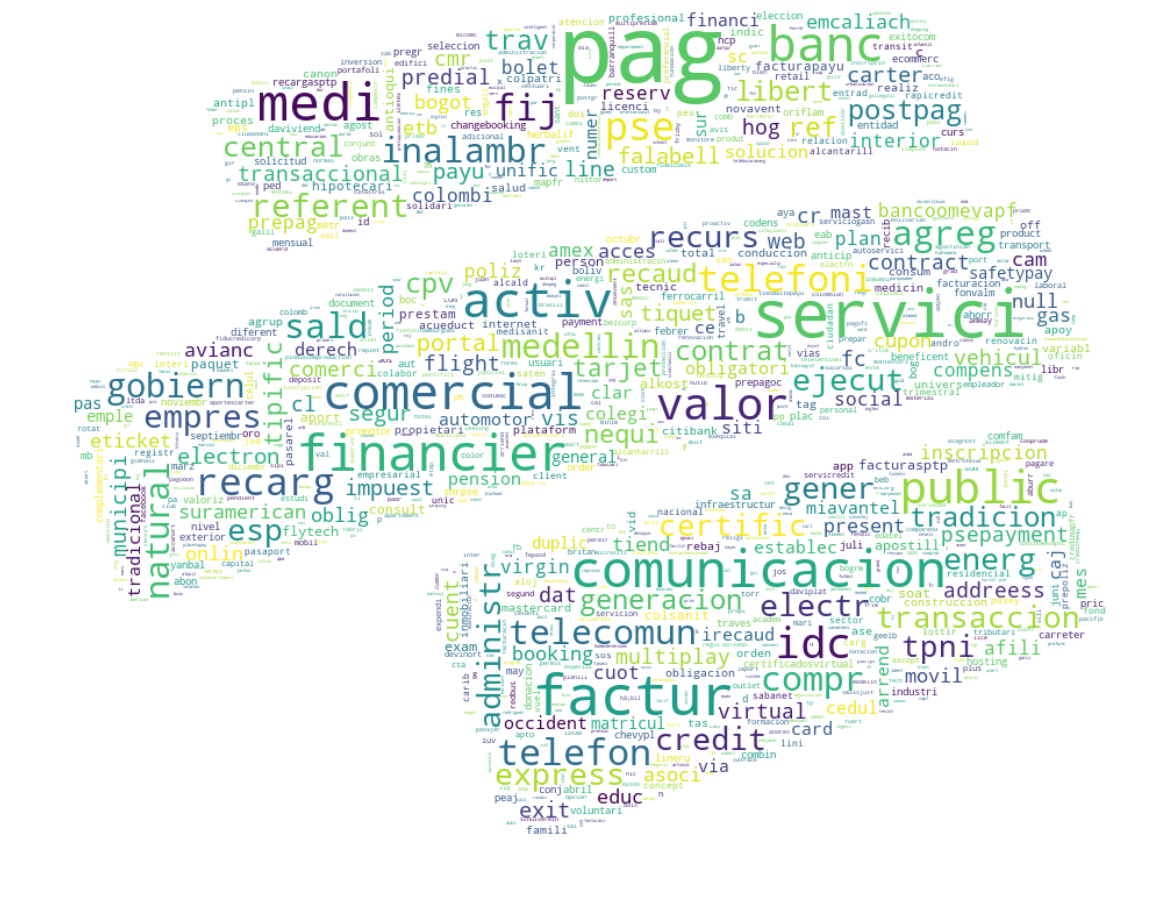

In [10]:
from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

alice_coloring = np.array(Image.open(path.join(d, "bancolombia.png")))

wc = WordCloud(background_color="white", max_words=2000, mask=alice_coloring,max_font_size=80, random_state=42)

wc.generate_from_frequencies(frequencies=h)

image_colors = ImageColorGenerator(alice_coloring)

fig, axes = plt.subplots(1, 1)

axes.imshow(wc, interpolation="bilinear")

fig.set_size_inches(20,20)
axes.set_axis_off()
plt.show()



### Word Cloud  sin procesar totalmente

In [13]:
rdd = sc.textFile("word_count_sin_procesar.csv")
h = list(rdd.take(800))

d = {}
lista = []

for i in h:
    i = i.replace("(","")
    i = i.replace(")","")
    i = i.replace("'","")
    i = i.replace(" ","")
    lista.append(i)

h = {}
for a in lista:
    a = a.split(',')
    h[a[0]] = int(a[1])


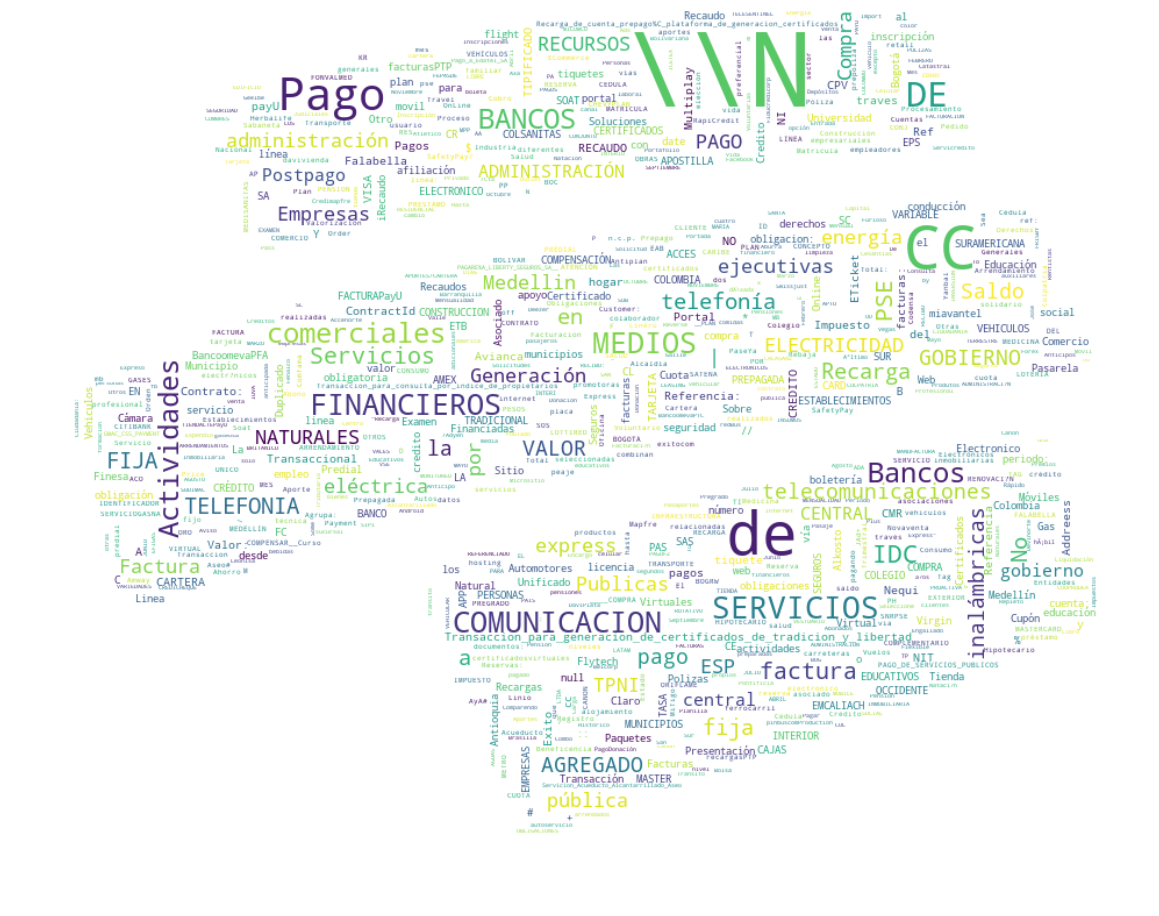

In [19]:
from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

alice_coloring = np.array(Image.open(path.join(d, "bancolombia.png")))

wc = WordCloud(background_color="white", max_words=800, mask=alice_coloring,max_font_size=90, min_font_size=4,random_state=42)

wc.generate_from_frequencies(frequencies=h)

image_colors = ImageColorGenerator(alice_coloring)

fig, axes = plt.subplots(1, 1)

axes.imshow(wc, interpolation="bilinear")

fig.set_size_inches(20,20)
axes.set_axis_off()
plt.show()

